In [1]:
# https://zhuanlan.zhihu.com/p/77063373
# https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Importing data
df = pd.read_csv('./data/jetrail_train.csv')
#Printing head
df.head()


,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [3]:
#Printing tail
df.tail()


,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


从上面的打印报表中可以看出，我们给出了2年(2012-2014年)的每小时数据，以及通勤者的数量，我们需要估计未来的通勤者数量。

在本文中，我们将把这份数据抽样并聚合到天级别再继续分析。

- 抽取2012年8月至2013年12月的数据，总共14个月
- 构建模型的训练数据和测试数据，前12个月（2012年8月到2013年10月）作为训练数据，后两个月的数据作为预测数据
- 聚合数据到天级别

<ipython-input-6-857dff92159f>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')
<ipython-input-6-857dff92159f>:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
<ipython-input-6-857dff92159f>:17: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')


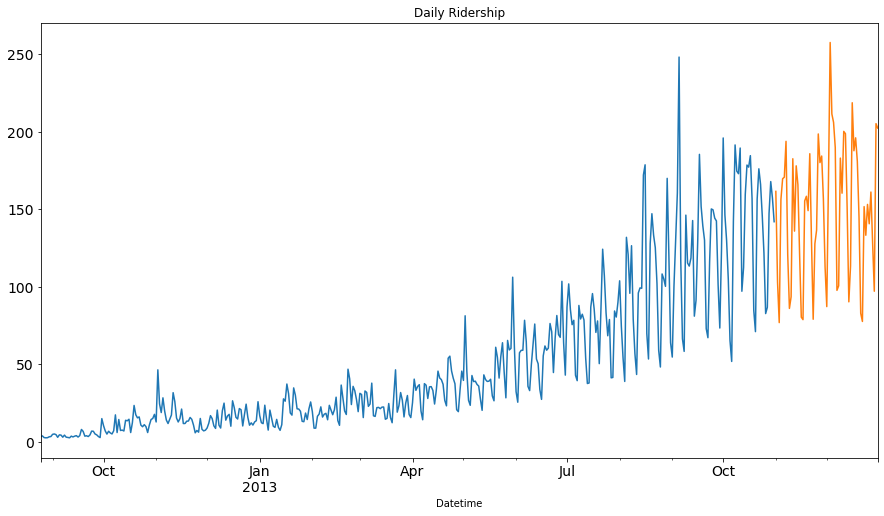

In [6]:
#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('./data/jetrail_train.csv', nrows = 11856)

#Creating train and test set
#Index 10392 marks the end of October 2013
train=df[0:10392]
test=df[10392:]

#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M')
df.index = df.Timestamp
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
train = train.resample('D').mean()
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
test.index = test.Timestamp
test = test.resample('D').mean()

#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

有时候整个时段的时间序列值是稳定的，如果想预测未来1天的值，我们只需要用1天前的数据作为预估值。
这种预估方法的核心假设是未来的数据和最新观测的数据是一样的，下面我们用代码实现：

> Method 1:**用前一天的数据作为预估值**

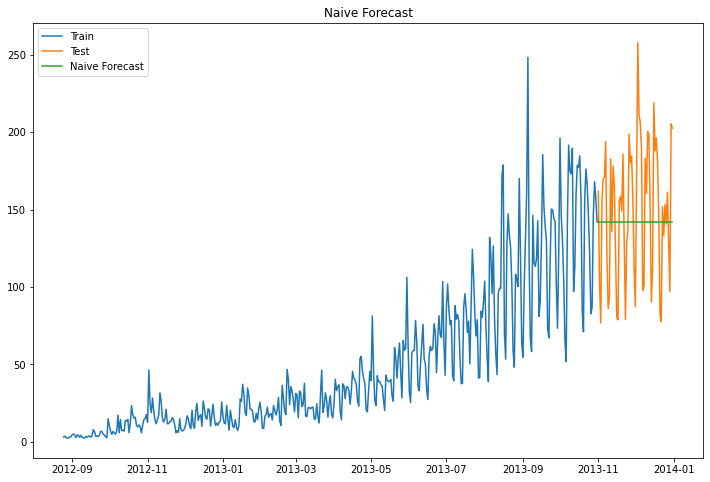

In [7]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


我们用RMSE在检查下预测的准确率


In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
rms


43.91640614391676

> Method 2:**用简单平均的数据作为预估值**

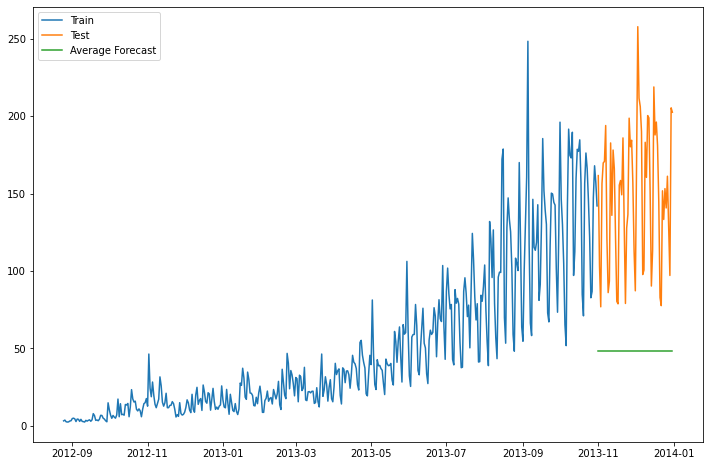

In [9]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()


In [10]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
rms

109.88526527082863

移动平均使用最近的k个观测值预测未来的时间序列

> Method 3:**用 移动平均 的数据作为预估值**

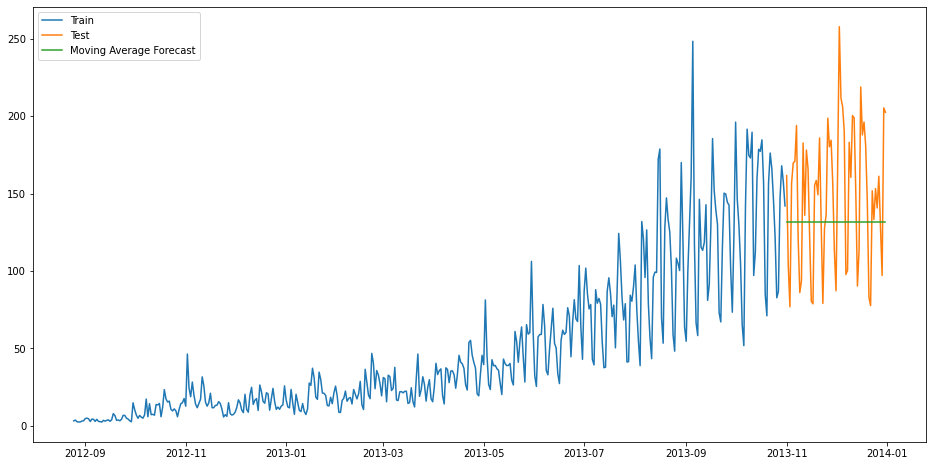

In [11]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()


In [12]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
rms


46.72840725106963

一种比移动平均法更好的方法是加权移动平均。在上面的移动平均法中，我们赋予最近的k个观测值同等权重，但加权移动平均会区别对待各个观测值。
加权移动平均需要指定权重，一般是最近的观测值权重更大，不需要设置时间窗口，我们一般给定一个权重数组，数组的和为1，比如[0.40, 0.25, 0.20, 0.15] 意味着给最近的4个观测值分别40%、25%、20%、15%的权重。

> Method 4:**用 单指数平滑法**

C:\Users\Enter\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


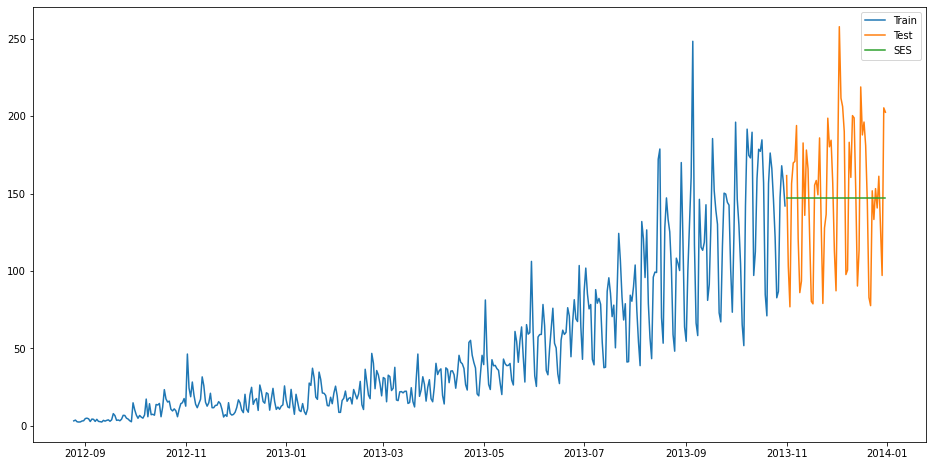

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [14]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
rms


43.357625225228155

> Method 5:**用 霍尔特线性趋势预测**

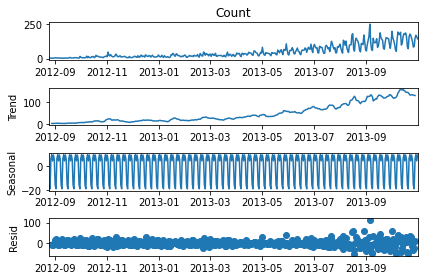

In [15]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

C:\Users\Enter\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-16-c649925420d7>:3: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)


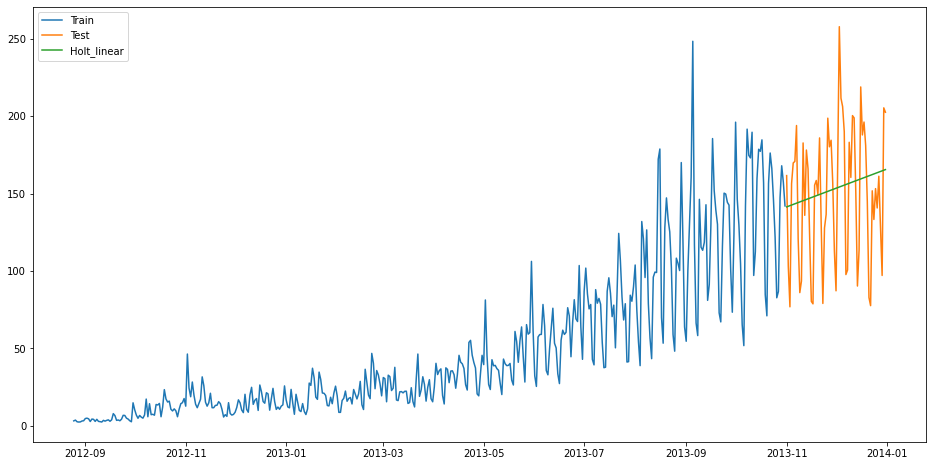

In [16]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [17]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
rms

43.056259611507286

> Method 6:**用 Holt-Winters Method**

C:\Users\Enter\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


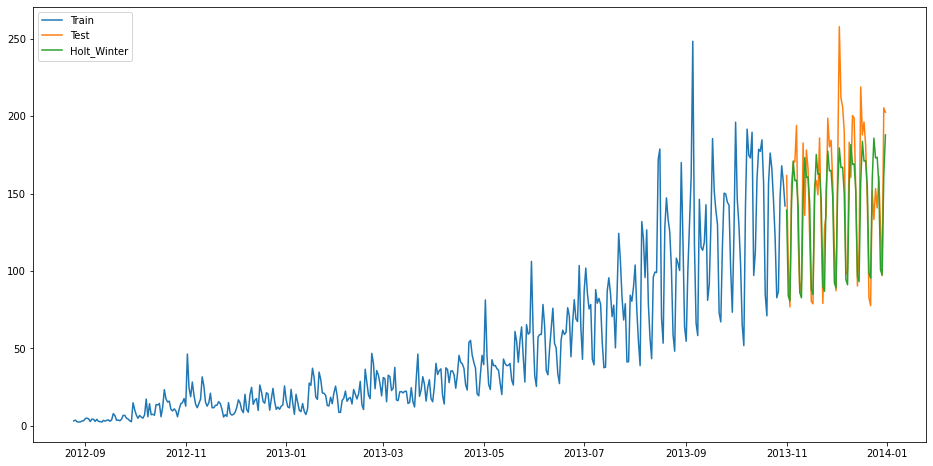

In [18]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [19]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
rms

25.26453787766697

SARIMA（Seasonal ARIMA）
> Method 7:**ARIMA**


C:\Users\Enter\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


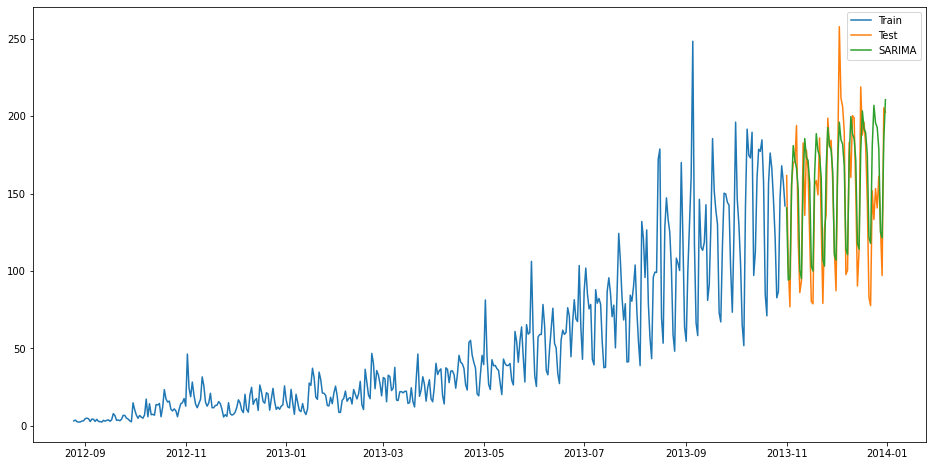

In [20]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [21]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
rms


26.059886067177032